In [1]:
import pandas as pd, numpy as np, geopandas as gpd, pingouin as pin, matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap, DivergingNorm
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('precision', 10)
%matplotlib inline

In [2]:
import cityImage as ci
import ABManalysis as af

## 0.1 Loading the urban elements layers

In [3]:
# initialise path, names, etc.
city_name = 'London'
epsg = 27700
crs = {'init': 'epsg:'+str(epsg), 'no_defs': True}

In [4]:
#initialise path, names, etc.

input_path = 'Input/landmarkNavigation/'+city_name
output_path = 'Outputs/landmarkNavigation/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')
landmarks = gpd.read_file(input_path+'_landmarks.shp', driver='ESRI Shapefile')
nodes.index, edges.index  = nodes.nodeID,  edges.edgeID
nodes.index.name, edges.index.name = None, None
landmarks.index = landmarks.buildingID
landmarks.index.name = None

unionStreet = edges.geometry.unary_union
convex_hull = unionStreet.convex_hull

## 0.2 Loading  the simulation's resulting volumes

In [5]:
input_path = 'Input/landmarkNavigation/'+city_name
columns = ['edgeID', 'RD','AC', 'RL', 'AL', 'LL', 'GL']
runs = 50
df_list = []

for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_landmarks_'+str(run)+'.csv')
    df_tmp = df_tmp[columns]
    for n, c in enumerate(df_tmp.columns): 
        df_tmp.rename(columns={c: columns[n]+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID0
for run in range(runs): 
    df.drop(['edgeID'+str(run)], axis = 1, inplace = True)

df_list = []
route_choice_models = ['RD','AC', 'RL', 'AL', 'LL', 'GL']
for model in route_choice_models: 
    df_list.append(df[[col for col in df if col.startswith(model)]+['edgeID']])

# aggregate runs values
edges = af.aggregate_runs(df_list, route_choice_models, edges, ddof = 0)

## 0.4 Loading the simulation's resulting routes

In [6]:
route_choice_models = ['RD', 'AC', 'RL', 'AL']

file_prefix = ['roadDistance', 'angularChange', 'roadDistanceLandmarks','angularChangeLandmarks']
input_path_routes = 'Input/landmarkNavigation/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_landmarks_routes_'+str(run)+'.shp')

    for n, model in enumerate(route_choice_models):
        model_gdf = run_gdf[run_gdf.routeChoic == model].copy()
        if run == 0:
            routes_gdf = model_gdf.copy()
            routes_gdfs.append(model_gdf)
            continue
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(model_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdfs[n] = routes_gdf

In [7]:
for n, model in enumerate(route_choice_models): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf

## 0.3 Loading tracks and counting

In [8]:
tracks = gpd.read_file(input_path+'_GPSIES_tracks.shp').to_crs(epsg=epsg)

lines_at_centroids = edges[['edgeID', 'u', 'v', 'geometry']].copy()
lines_at_centroids['geometry'] = edges.apply(lambda row: af.line_at_centroid(row['geometry'], 2), axis = 1)
edges['counts'] = lines_at_centroids.apply(lambda row: af.count_at_centroid(row['geometry'], tracks), axis = 1)

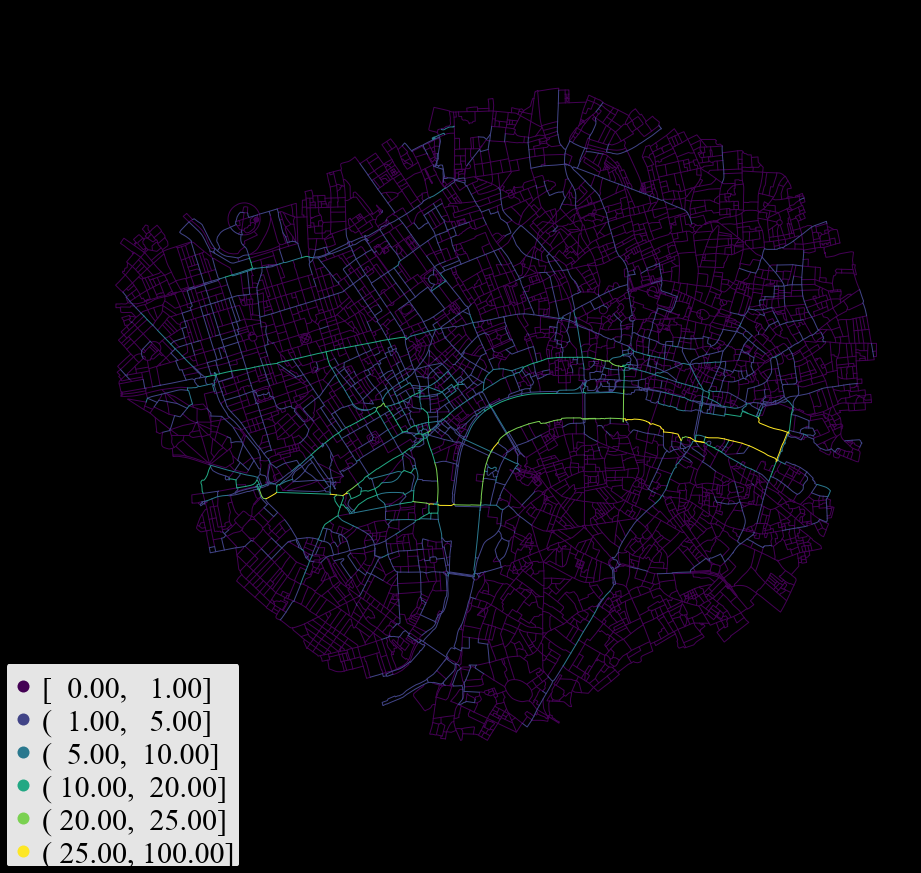

In [9]:
# visualise
bins = [1,5, 10, 20, 25, 100]
ci.plot_gdf(edges, lw = 1, column = 'counts', bins = bins, scheme = 'User_Defined', cmap = 'viridis', legend = True,
            fig_size = 15)

# 1. Landmarkness
## 1.1 Computing Landmarkness on Routes

In [10]:
# incorporate landmarks into the street network.

sight_lines = gpd.read_file(input_path+'_sight_lines2D.shp', driver='ESRI Shapefile')
nodes = af.assign_local_landmarks_to_nodes(nodes, landmarks, radius = 50)
nodes = af.assign_3d_visible_landmarks_to_nodes(nodes, landmarks, sight_lines, threshold = 0.3)

# nr_anchors associated with the destination (e.g. first best five are kept).
# the higher the number, the higher the resulting landmarkness of a route, as it's likely that more anchors are visible.
# this affects computation speed too in the landmarkness computation below.
nodes = af.assign_anchors_to_nodes(nodes, landmarks, radius = 2000, threshold = 0.3, nr_anchors = 5)

In [12]:
for n, model in enumerate(route_choice_models):
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['lL'] = routes_gdf.apply(lambda row: af.local_landmarkness_route(row, nodes, edges, landmarks), axis = 1)
    routes_gdf['gL'] = routes_gdf.apply(lambda row: af.global_landmarkness_route(row, nodes, edges, landmarks), axis = 1)
    routes_gdfs[n] = routes_gdf

In [ ]:
# saving
for n, model in enumerate(route_choice_models):
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf.drop('edgeIDs', axis = 1).to_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')

In [16]:
for n, model in enumerate(route_choice_models):
    print(model)
    print('    local_landmarkness - median', routes_gdfs[n].lL.mean())
    print('    global_landmarkness - median', routes_gdfs[n].gL.median())

RD
    local_landmarkness - median 32.68380569259963
    global_landmarkness - median 3.732886052122474
AC
    local_landmarkness - median 33.00884533839343
    global_landmarkness - median 4.6344187373455314
RL
    local_landmarkness - median 36.45982583175206
    global_landmarkness - median 8.916113574002726
AL
    local_landmarkness - median 36.414281290322585
    global_landmarkness - median 7.5342975425128484


In [ ]:
# reloading data
routes_gdfs = []
route_choice_models = ['RD', 'AC', 'RL', 'AL']
for n, model in enumerate(route_choice_models):
    routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

## 1.2 Computing Landmarkness on GPS tracks

In [14]:
tracks[['origin', 'destination']] = tracks.apply(lambda row: af.find_tracks_OD(row['uniqueID'], row['geometry'], convex_hull, 
                                    nodes), axis = 1, result_type='expand')
tracks['traversed_nodes'] = tracks.apply(lambda row: af.traversed_nodes(row['geometry'], lines_at_centroids), axis =1)

In [18]:
tracks['lL'] = tracks.apply(lambda row: af.local_landmarkness_track(row['traversed_nodes'], nodes, landmarks), axis = 1)
tracks['gL'] = tracks.apply(lambda row: af.global_landmarkness_track(row['destination'], row['traversed_nodes'], nodes, 
                                                                     landmarks), axis = 1)
# saving
tracks.drop('traversed_nodes', axis = 1).to_file(output_path+'_tracks_stats.shp')
print("GPS trajectories")
print('    local_landmarkness', tracks['lL'].median())
print('    global_landmarkness', tracks['gL'].median())

GPS trajectories
    local_landmarkness 37.5425806451613
    global_landmarkness 7.7731607029395615


## 1.3 Significance test on landmarkness

In [25]:
#for boxplot
route_choice_models = ['RD scenario', 'AC scenario', 'RL scenario', 'AL scenario']
labels = ['lL', 'gL']
titles = ['Local Landmarkness', 'Global Landmarkness']

routes_stats = af.generate_routes_stats(routes_gdfs, route_choice_models, labels, titles)
trajectory_stats = af.generate_routes_stats([tracks], ['Trajectories'], labels, titles)
routes_stats = routes_stats.append(trajectory_stats)
routes_stats = routes_stats.reset_index(drop = True)

In [26]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats['type'] == 'Local Landmarkness'], dv= 'values', 
                         between = 'routeChoice', tail = 'two sided', alpha = 0.05)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC scenario,AL scenario,33.009,36.414,-3.405,0.166,two sided,-14.483,25248.318,0.0010000000,-0.181
1,AC scenario,RD scenario,33.009,32.684,0.325,0.159,two sided,1.443,25488.714,0.4999986197,0.018
2,AC scenario,RL scenario,33.009,36.460,-3.451,0.168,two sided,-14.542,25160.061,0.0010000000,-0.182
3,AC scenario,Trajectories,33.009,43.684,-10.675,1.618,two sided,-4.664,241.288,0.0010000000,-0.304
4,AL scenario,RD scenario,36.414,32.684,3.730,0.168,two sided,15.728,25333.792,0.0010000000,0.197
5,AL scenario,RL scenario,36.414,36.460,-0.046,0.176,two sided,-0.183,25490.940,0.9000000000,-0.002
6,AL scenario,Trajectories,36.414,43.684,-7.269,1.619,two sided,-3.174,241.795,0.0134836625,-0.207
7,RD scenario,RL scenario,32.684,36.460,-3.776,0.169,two sided,-15.776,25260.218,0.0010000000,-0.198
8,RD scenario,Trajectories,32.684,43.684,-11.000,1.619,two sided,-4.805,241.377,0.0010000000,-0.313
9,RL scenario,Trajectories,36.460,43.684,-7.224,1.619,two sided,-3.154,241.889,0.0143868804,-0.205


In [27]:
pin.pairwise_gameshowell(data = routes_stats[routes_stats.type == 'Global Landmarkness'], dv= 'values', 
                         between = 'routeChoice', tail = 'two sided', alpha = 0.05)

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,AC scenario,AL scenario,7.734,11.617,-3.883,0.098,two sided,-28.044,24161.036,0.0010000000,-0.351
1,AC scenario,RD scenario,7.734,7.286,0.448,0.083,two sided,3.799,25421.336,0.0013703937,0.048
2,AC scenario,RL scenario,7.734,12.402,-4.668,0.099,two sided,-33.460,24035.880,0.0010000000,-0.419
3,AC scenario,Trajectories,7.734,11.955,-4.222,0.582,two sided,-5.126,244.252,0.0010000000,-0.334
4,AL scenario,RD scenario,11.617,7.286,4.331,0.096,two sided,31.920,23564.447,0.0010000000,0.400
5,AL scenario,RL scenario,11.617,12.402,-0.785,0.109,two sided,-5.070,25494.264,0.0010000000,-0.063
6,AL scenario,Trajectories,11.617,11.955,-0.338,0.584,two sided,-0.410,247.511,0.9000000000,-0.027
7,RD scenario,RL scenario,7.286,12.402,-5.116,0.097,two sided,-37.411,23424.445,0.0010000000,-0.469
8,RD scenario,Trajectories,7.286,11.955,-4.670,0.582,two sided,-5.673,243.703,0.0010000000,-0.370
9,RL scenario,Trajectories,12.402,11.955,0.447,0.584,two sided,0.540,247.722,0.9000000000,0.035


(0.0, 120.0)

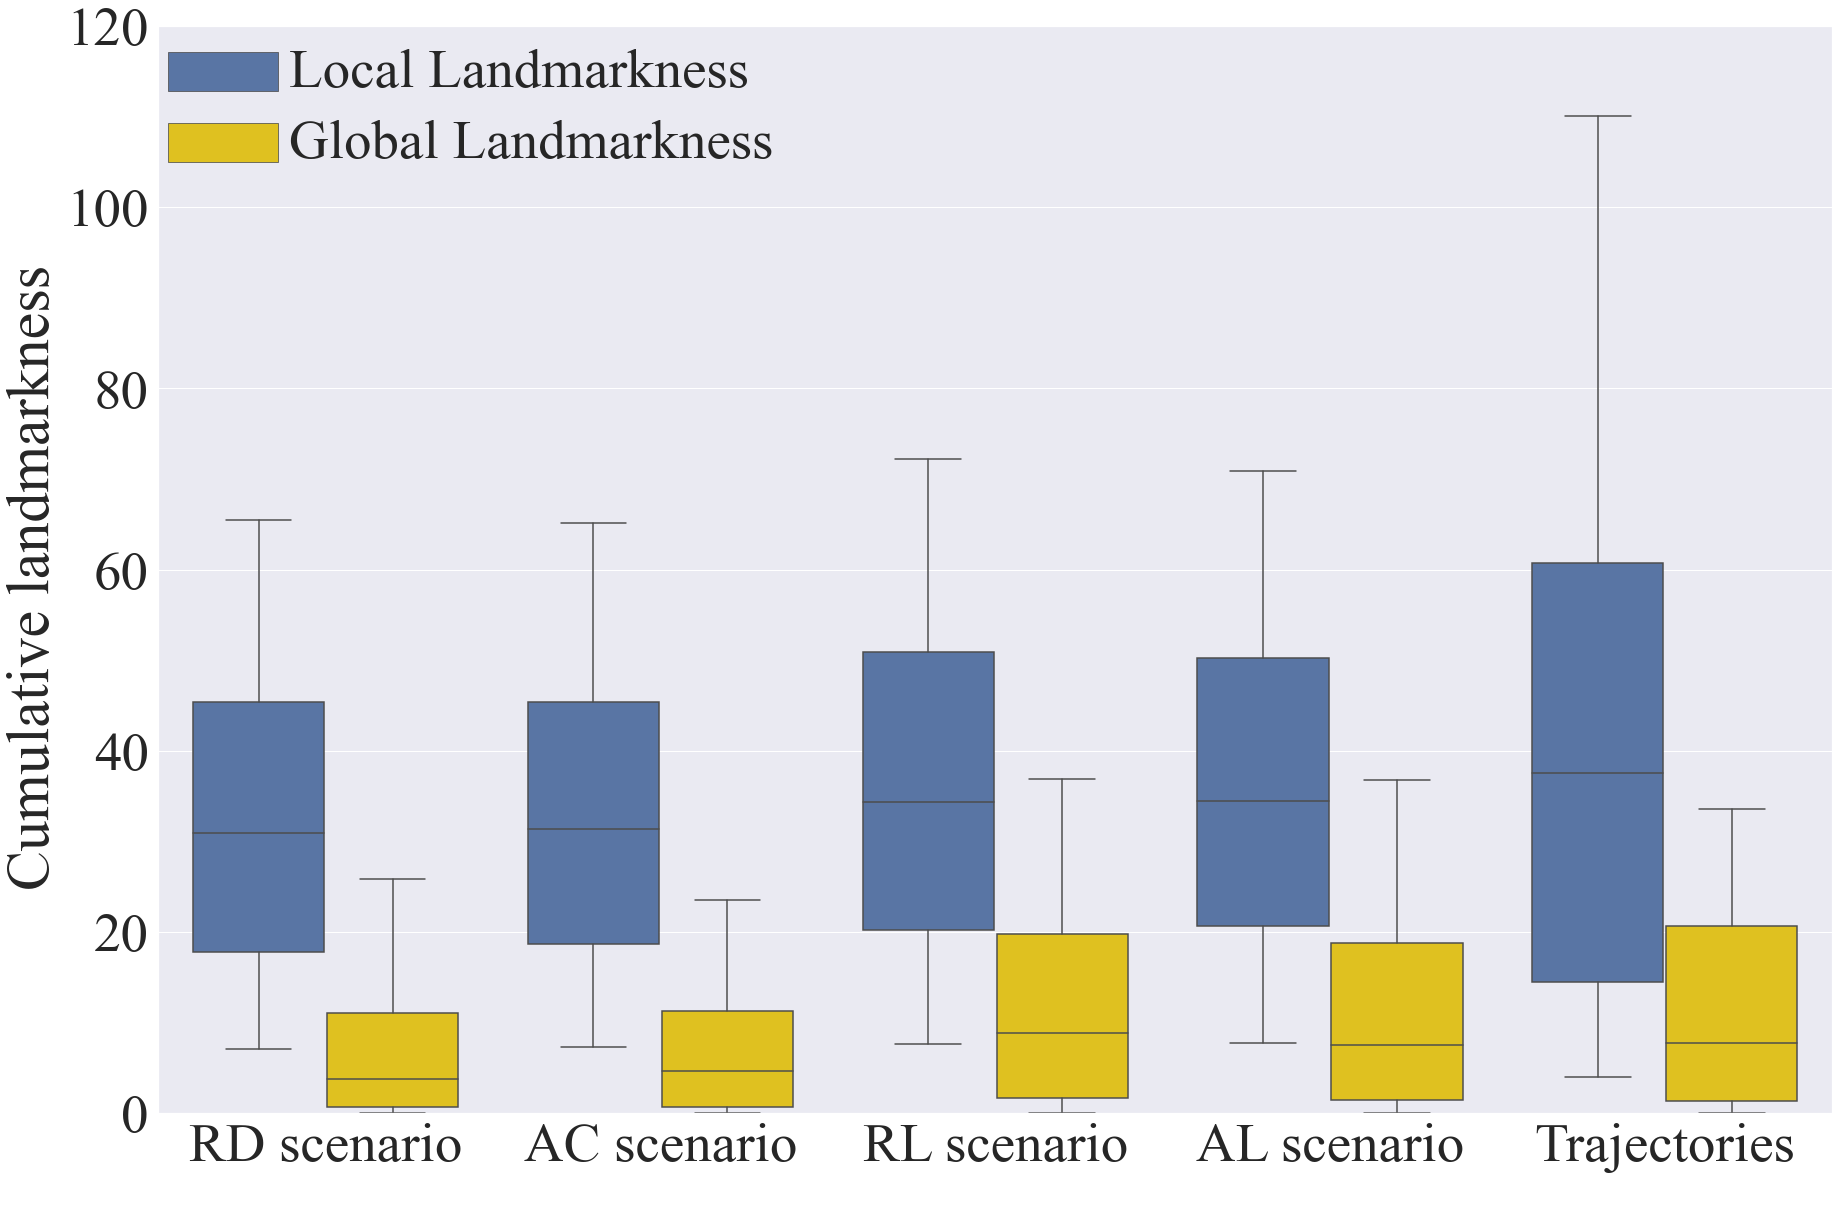

In [31]:
fig = plt.figure()
sns.set_color_codes()

sns.set(rc={'figure.figsize':(30, 20)})
ax = sns.boxplot(x='routeChoice', y='values', hue = 'type', data= routes_stats, palette = ['b', 'gold'], whis = [5,95], 
                 showfliers = False)

plt.legend(frameon=False, handletextpad= 1, labelspacing=1.5, prop={'family':'Times New Roman'})
plt.setp(ax.get_legend().get_texts(), fontsize='55', va='center') # for legend text

plt.rcParams['legend.handleheight'] = 5
plt.rcParams['legend.handlelength'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
ax.tick_params(axis='both', which='major', labelsize= 55)
ax.set_xlabel(' ', fontsize = 30)
ax.set_ylabel('Cumulative landmarkness ', fontsize = 60, fontfamily = 'Times New Roman')

for tick in ax.get_yticklabels():
    tick.set_fontname('Times New Roman')
    
for tick in ax.get_xticklabels():
    tick.set_fontname('Times New Roman')

ax.set_ylim(0.0, 120)

In [33]:
fig.savefig('Outputs/Figures/F7.pdf', bbox_inches='tight')

# 2. Scenarios comparison

## 2.1 Median across the runs

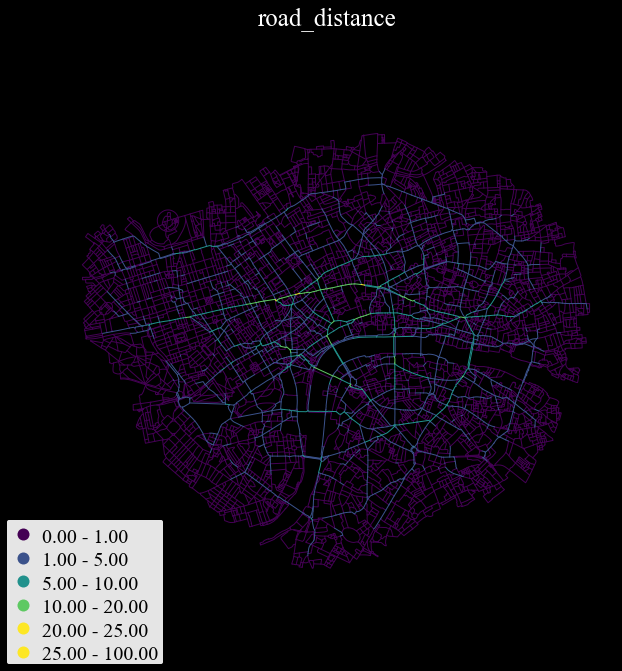

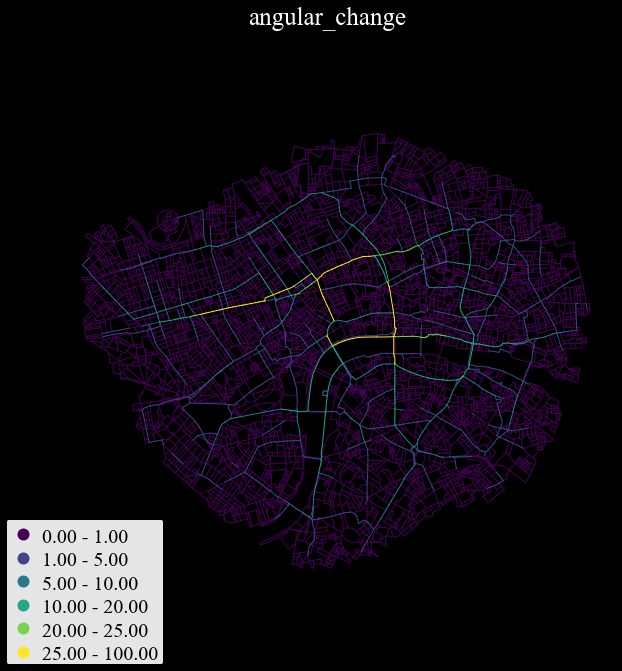

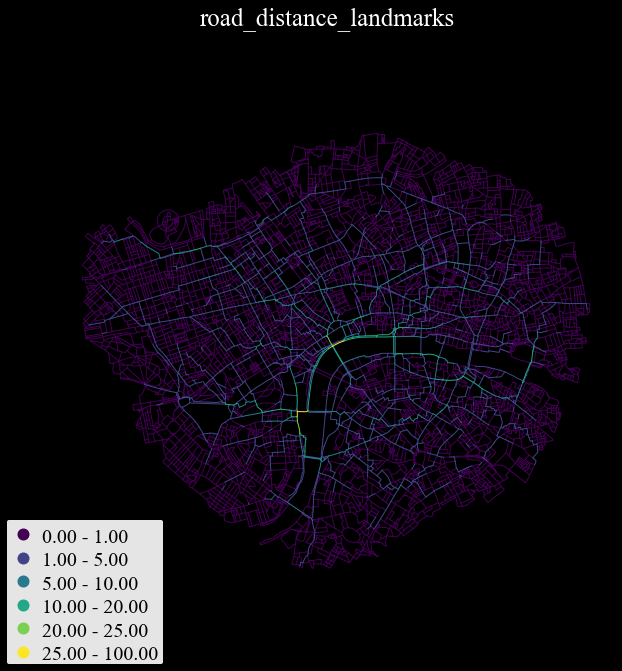

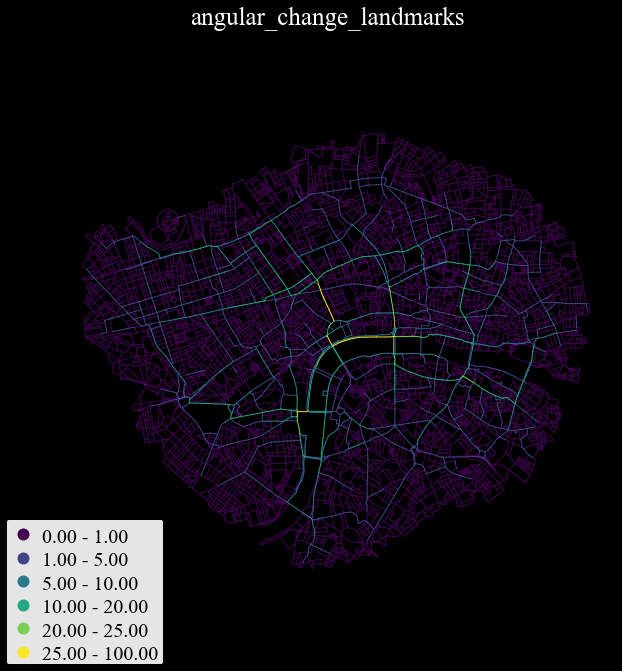

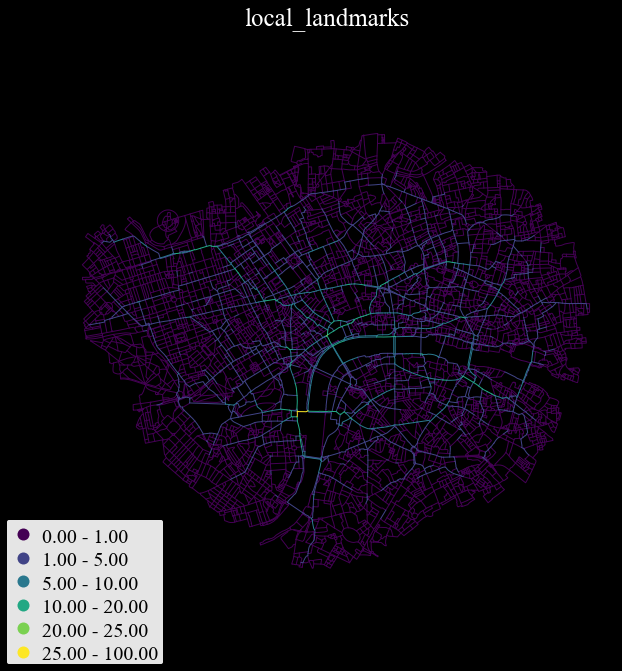

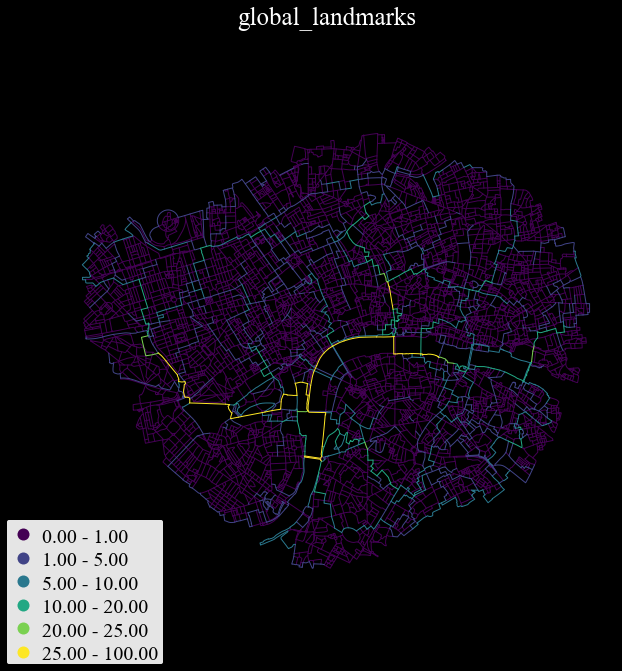

In [68]:
titles = ['road_distance', 'angular_change', 'road_distance_landmarks','angular_change_landmarks', 
         'local_landmarks', 'global_landmarks']

bins = [1, 5, 10, 20, 25, 100]
for n, model in enumerate(route_choice_models):
    ci.plot_gdf(edges, lw = 1, column = model, title = titles[n], bins = bins, scheme = 'User_Defined', 
                    cmap = 'viridis', legend = True, fig_size = 10)

## 2.2 Statistics and direct comparison

In [38]:
titles =['Road distance scenario','Angular change scenario',  'Road distance-landmark scenario', 
         'Angular Change-landmark scenario', 'Local Landmarks', ' Global Landmarks']
route_choice_models = ['RD','AC', 'RL','AL', 'LL', 'GL']
num_trips = 255

for n, model in enumerate(route_choice_models):
    
    print(titles[n]+' mean length is ', (edges[model+'_mean']*edges['length']).sum()/num_trips)
    print(titles[n]+' mean is ', edges[model].mean())
    print(titles[n]+' STD is ', edges[model].std())
    print(titles[n]+' max is ', edges[model].max())
    print(titles[n], ' segments higher than 1 ', len(edges[edges[model] >= 1]))
    print(titles[n], ' segments higher than 5 ', len(edges[edges[model] >= 5]))
    print()

Road distance scenario mean length is  3350.956159961524
Road distance scenario mean is  0.9598283328178163
Road distance scenario STD is  1.9186611477859012
Road distance scenario max is  21.5
Road distance scenario  segments higher than 1  5053
Road distance scenario  segments higher than 5  605

Angular change scenario mean length is  3910.833044062617
Angular change scenario mean is  1.0226183111660996
Angular change scenario STD is  3.391873384028591
Angular change scenario max is  35.0
Angular change scenario  segments higher than 1  3015
Angular change scenario  segments higher than 5  770

Road distance-landmark scenario mean length is  3953.6805785067436
Road distance-landmark scenario mean is  1.0719532941540364
Road distance-landmark scenario STD is  2.0500899682389733
Road distance-landmark scenario max is  34.5
Road distance-landmark scenario  segments higher than 1  5421
Road distance-landmark scenario  segments higher than 5  713

Angular Change-landmark scenario mean le

### Correlation amongst scenarios

In [101]:
route_choice_models = ['RD','AC', 'RL', 'AL', 'GL', 'LL']
for model in route_choice_models: 
    print()
    for other in route_choice_models: print('correlation '+model+' and :'+other, np.corrcoef(edges[model], edges[other])[0][1])


correlation RD and :RD 0.9999999999999999
correlation RD and :AC 0.5515424892339169
correlation RD and :RL 0.627534379623456
correlation RD and :AL 0.5798451671528351
correlation RD and :GL 0.12490842312701066
correlation RD and :LL 0.7764828269675584

correlation AC and :RD 0.5515424892339169
correlation AC and :AC 1.0
correlation AC and :RL 0.41508511461579495
correlation AC and :AL 0.8398218484302999
correlation AC and :GL 0.22744021142334608
correlation AC and :LL 0.4413867251142034

correlation RL and :RD 0.627534379623456
correlation RL and :AC 0.41508511461579495
correlation RL and :RL 1.0
correlation RL and :AL 0.6487087284040377
correlation RL and :GL 0.34623627946851443
correlation RL and :LL 0.8139124456017459

correlation AL and :RD 0.5798451671528351
correlation AL and :AC 0.8398218484302997
correlation AL and :RL 0.6487087284040376
correlation AL and :AL 0.9999999999999999
correlation AL and :GL 0.35673619729642986
correlation AL and :LL 0.6651766132368234

correlation G

## 2.3 Distribution plots

### Log-Log Plots

[None, None, None, None, None, None, None, None, None, None]

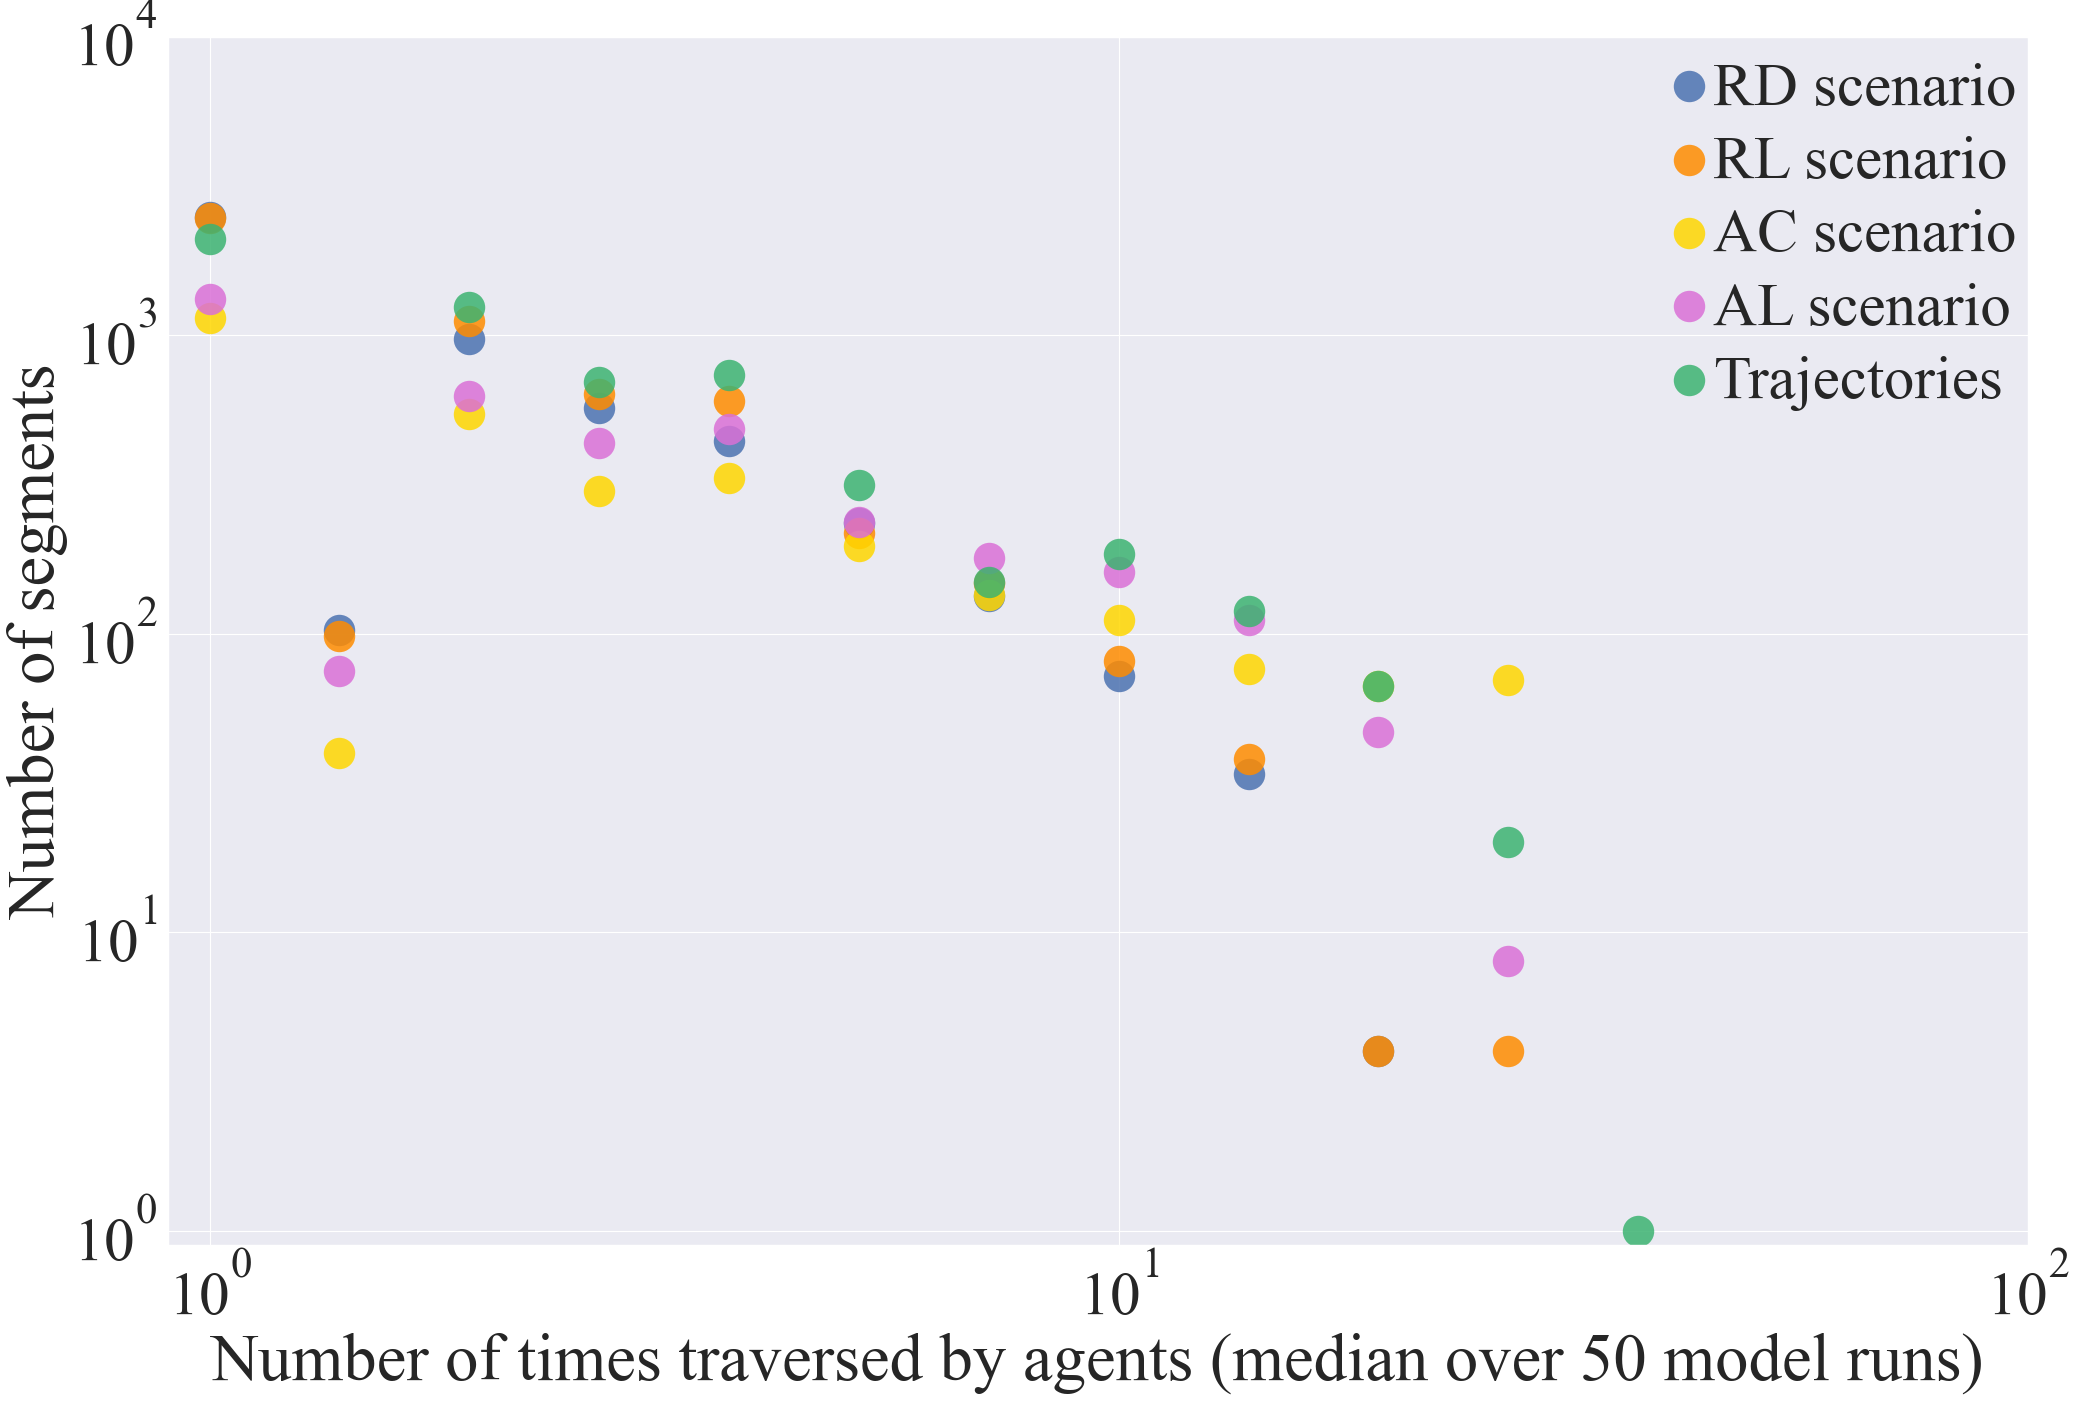

In [475]:
colors = ['b', 'darkorange', 'gold', 'orchid', 'mediumseagreen']
bins = 10**np.linspace(np.log10(1.0), np.log10(100), 15)
route_choice_models = ['RD', 'RL', 'AC', 'AL', 'counts']
labels =['RD scenario','RL scenario',  'AC scenario', 'AL scenario', 'Trajectories']
fig = plt.figure(figsize=(30, 20), dpi=80)
sns.set()
sns.set_color_codes()

for n, i in enumerate(route_choice_models):
    
    data = edges[i]
    freq, lim = np.histogram(a = data, bins=bins)
    sns.set_style("darkgrid")
    
    ax = sns.scatterplot(x=bins[:-1], y = freq, s = 800, linewidth='0', color = colors[n], alpha = 0.85, label = labels[n])  
    sns.set_style("darkgrid")
    ax.set(yscale='log')
    ax.set(xscale='log')
    ax.set_ylim(0.9, 10000)
    ax.set_xlim(0.9, 100)
    ax.tick_params(axis='both', which='major', labelsize= 55)
    ax.set_xlabel('Number of times traversed by agents (median over 50 model runs)', fontsize = 60, 
                  fontfamily = 'Times New Roman')
    ax.set_ylabel('Number of segments',  fontsize = 60, fontfamily = 'Times New Roman')
#     ax.yaxis.grid(True)
    for tick in ax.get_yticklabels():
        tick.set_fontname('Times New Roman')

    for tick in ax.get_xticklabels():
        tick.set_fontname('Times New Roman')

#     ax.set_frame_on(False)


legend = plt.legend(frameon=False, handletextpad= 1, labelspacing=1.5, prop={'family':'Times New Roman'})
plt.setp(legend.get_texts(), fontsize='55', verticalalignment='center') # for legend text    

In [93]:
fig.savefig('Outputs/Figures/F8.pdf', bbox_inches='tight')

## 3. Model Evaluation
### Median scenario vs observational data counts

In [473]:
route_choice_models = ['RD','AC', 'RL', 'AL']
max_err = 200
edges = af.compute_deviation_from(edges, route_choice_models, comparison = 'counts', max_err = max_err)

for model in route_choice_models:
    rmse = sqrt(((edges[model]-edges['counts'])**2).sum()/len(edges))
    print(model, 'rmse is ', rmse)

RD rmse is  2.9622358917721154
AC rmse is  3.892860791337928
RL rmse is  3.0057585982585593
AL rmse is  3.3742860765569396


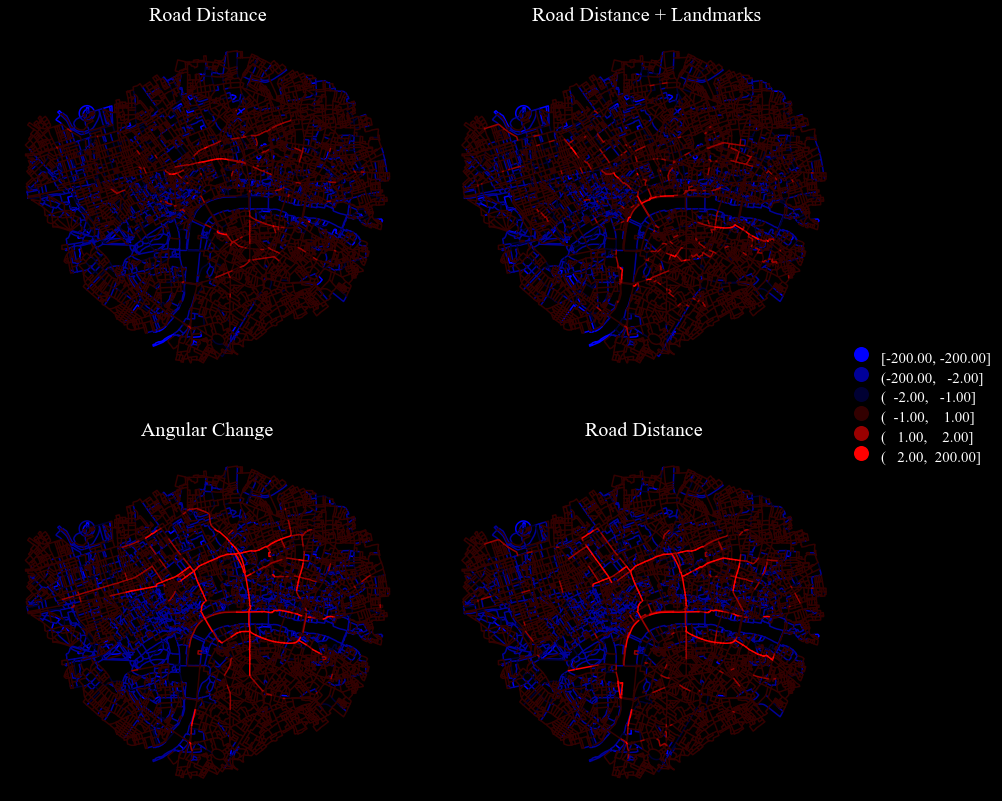

In [474]:
route_choice_models = ['RD_std_err', 'RL_std_err', 'AC_std_err', 'AL_std_err']
titles = ['Road Distance', ' Road Distance + Landmarks', 'Angular Change', 'Road Distance', 'Angular Change + Landmarks']
bins = [-max_err, -2, -1, +1, +2,+max_err]

## visualisation
cmap = LinearSegmentedColormap.from_list('BkR',['blue','black','red'])

fig = ci.plot_gdf_grid(gdf = edges, columns = route_choice_models, titles = titles, black_background = True, fig_size = 15, 
                 scheme = 'User_Defined', legend = True, bins = bins, cmap = cmap, axis_frame = False, lw = 1.5)

### Saving volumes and stats

In [99]:
edges.to_file(output_path+'_pedSim_LR.shp',  use_unicode=True, driver='ESRI Shapefile')